# ENC - master Humanités numériques

# Évaluation pour le cours d'apprentissage machine : question 3

## Question : approche non supervisée pour CIFAR10
Proposez une approche non supervisée pour classer les données CIFAR10.

## Proposition

Selon mes connaissances actuelles, trois méthodes de clustering pourraient être envisagées :
- K-Means
- classification ascendante hiérarchique (CAH)
- DBSCAN

On ne regardera que K-Means et CAH par la suite.

Par ailleurs, le jeu de données comporte un nombre important de caractéristiques (plus de 3000). On se demandera si cela a un impact en termes de performances (on entend par là la capacité à faire fonctionner l'algorithme sur une machine fournie par Colab) et la qualité des regroupements en testant différentes réductions de la dimensionnalité (en recourant à une analyse par composantes principales - ACP ou PCA en anglais).

## Mise en oeuvre

### On importe les différents modules et le jeu de données

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd

In [0]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# on normalise la valeur des pixels
x_train, x_test = x_train / 255.0, x_test / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

On transforme les données qu'elles correspondent à un tableau pour chaque ligne une image et pour chaque pixel une colonne correspondant aux informations R, G, B.

In [3]:
print(f"x_train : {x_train.shape}")
print(f"x_test : {x_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

x_train : (50000, 32, 32, 3)
x_test : (10000, 32, 32, 3)
y_train : (50000, 1)
y_test : (10000, 1)


In [0]:
flat_x_train = x_train.reshape(50000,3072)
flat_x_test = x_test.reshape(10000,3072)

Dans la mesure où l'on effectue du clustering, on n'a pas besoin de distinguer données d'entraînement et de test, on peut donc les fusionner.

In [4]:
X = np.concatenate((flat_x_train, flat_x_test), axis=0)
print(X.shape)
Y = np.concatenate((y_train, y_test), axis=0)
print(Y.shape)

(60000, 3072)
(60000, 1)


### Etape 1 : on construit une *ACP*

On limite arbitrairement à 800 le nombre de composantes.

In [0]:
pca = PCA(n_components=800)

In [6]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=800, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
X_pca = pca.transform(X)

On crée par curiosité une réprensation graphique des deux premières composantes. On en déduit que l'ACP ne permettra pas de réaliser de clustering (un seul groupe (ici en bleu ciel) semble se dégager).

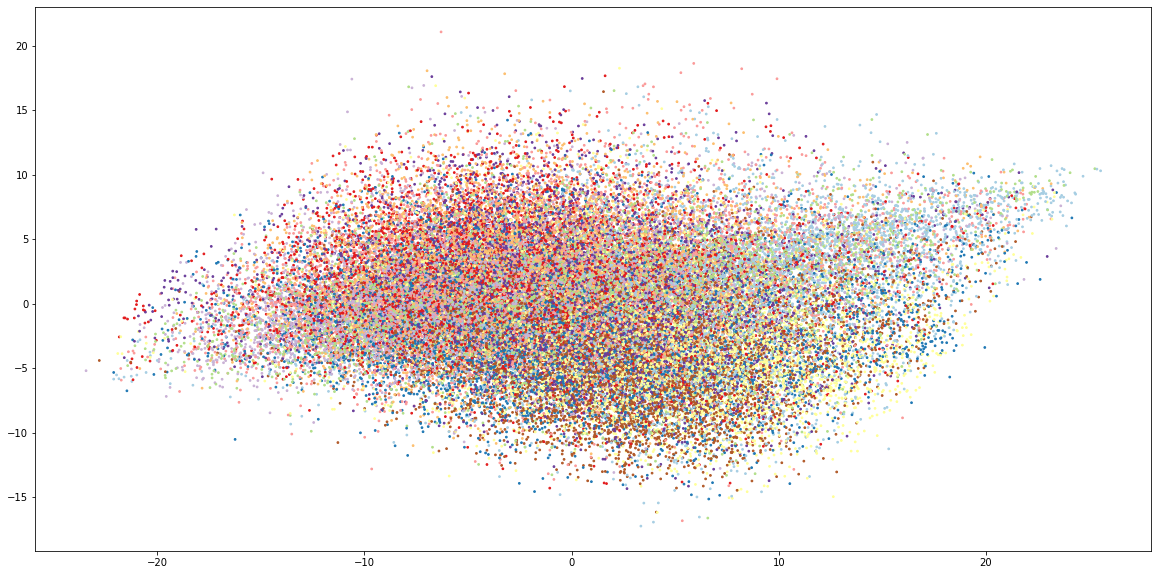

In [9]:
plt.figure(figsize=(20,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=3, c=Y, cmap=plt.cm.Paired)

On crée un tableau (qu'on exporte sous forme de fichier csv par commodité) et un graphique de la variance expliquée cumulée.

In [0]:
pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)).to_csv('cumsum_explained_variance_800.csv')

Text(0.5, 1.0, 'Variance expliquée cumulée')

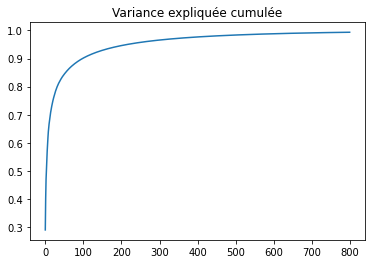

In [11]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Variance expliquée cumulée')

Le jeu de données comprend 3072 caractéristiques (32 * 32 * 3).
En redistribuant l'information via une ACP, on peut expliquer :
- 99 % de la variance grâce à 531 composantes,
- 95 % de la variance grâce à 212 composantes.

On testera donc par la suite les différents algorithmes à la fois sur l'ensemble des caractéristiques, puis respectivement 531 et 212 composantes principales.

### Etape 2 : essais de regroupements par clustering

#### Avec K-Means

On crée 3 regroupements, respectivement sur l'ensemble des caractéristiques ('kmeans_all') puis sur 531 ('kmeans531') puis 212 ('kmeans212') composantes.

In [0]:
kmeans_all = KMeans(n_clusters=10, random_state=5).fit(X)

In [0]:
kmeans531 = KMeans(n_clusters=10, random_state=5).fit(X_pca[:,:531])

In [0]:
kmeans212 = KMeans(n_clusters=10, random_state=5).fit(X_pca[:,:212])

On regarde ensuite pour chacun d'entre eux les matrices de confusion, pour essayer de déterminer si un groupe permet de bien regrouper les éléments d'une classe.

> Attention, ces matrices ne peuvent pas se lire de la même manière que pour un problème de classification : les labels des groupes sont attribués de manière aléatoire (et ne peuvent donc être comparés d'un test à l'autre). On éviter les confusions, on indiquera en ligne le nom des classes CIFAR10 et en colonnes le label proposé par K-Means.



In [15]:
cm = pd.DataFrame(confusion_matrix(Y[:,0], kmeans_all.labels_),
                  index=class_names)
print("Matrice de confusion 'kmeans_all'")
cm

Matrice de confusion 'kmeans_all'


,0,1,2,3,4,5,6,7,8,9
airplane,249,343,1187,493,915,645,587,164,1146,271
automobile,592,513,183,492,583,1033,992,464,261,887
bird,718,1394,641,367,213,399,322,411,444,1091
cat,829,977,549,461,143,572,394,910,308,857
deer,726,1322,393,209,207,307,337,1117,140,1242
dog,665,978,732,343,112,1024,249,1026,196,675
frog,1286,1225,170,461,53,444,175,558,205,1423
horse,373,1206,364,676,252,479,859,882,140,769
ship,226,203,631,208,1894,1032,1075,256,285,190
truck,162,462,166,716,906,504,2056,194,200,634


In [16]:
cm = pd.DataFrame(confusion_matrix(Y[:,0], kmeans531.labels_),
                  index=class_names)
print("Matrice de confusion 'kmeans531'")
cm

Matrice de confusion 'kmeans531'


,0,1,2,3,4,5,6,7,8,9
airplane,1147,158,351,914,273,650,491,1179,250,587
automobile,256,471,521,588,889,1027,489,182,591,986
bird,443,417,1395,216,1092,400,366,636,714,321
cat,307,913,978,143,858,569,459,551,829,393
deer,139,1123,1326,206,1243,310,209,390,721,333
dog,196,1042,974,111,678,1013,340,736,664,246
frog,205,569,1221,53,1440,427,458,174,1282,171
horse,139,886,1211,251,769,474,673,364,373,860
ship,281,254,204,1889,191,1046,209,623,225,1078
truck,200,192,470,890,637,512,716,162,163,2058


In [19]:
cm = pd.DataFrame(confusion_matrix(Y[:,0], kmeans212.labels_),
                  index=class_names)
print("Matrice de confusion 'kmeans212'")
cm

Matrice de confusion 'kmeans212'


,0,1,2,3,4,5,6,7,8,9
airplane,250,1178,273,158,585,352,490,1147,651,916
automobile,592,181,886,472,988,520,489,257,1028,587
bird,714,633,1097,417,322,1390,367,443,401,216
cat,830,553,860,911,391,977,458,308,569,143
deer,723,390,1244,1123,333,1321,209,139,312,206
dog,665,733,682,1042,247,970,338,196,1014,113
frog,1285,174,1439,569,172,1213,457,205,433,53
horse,374,364,772,884,859,1209,673,139,474,252
ship,226,618,190,255,1074,205,205,283,1047,1897
truck,164,160,634,192,2057,473,713,200,513,894


Interprétation :


#### Avec CAH

On tente de réaliser une CAH sur le jeu de données. Après plusieurs tentatives infructueuses (plantage par manque de RAM), on limite le nombre d'images. On crée donc les mêmes regroupements que précédemment, mais avec 30 000 images seulement.

In [0]:
cah = AgglomerativeClustering(linkage="ward",n_clusters=10)
clusters_labels212 = cah.fit_predict(X_pca[:30000,:212])

In [0]:
clusters_labels531 = cah.fit_predict(X_pca[:30000,:531])

In [0]:
clusters_labels_all = cah.fit_predict(X[:30000,:])

In [0]:
pd.DataFrame({'cl212': clusters_labels212, 'cl531': clusters_labels531, 'cl_all': clusters_labels_all}).to_csv("clusters.csv", index=True, header=True)

On regarde les matrices de confusion

In [17]:
cm = pd.DataFrame(confusion_matrix(Y[:30000,0], clusters_labels_all),
                  index=class_names)
print("Matrice de confusion 'clusters_labels_all'")
cm

Matrice de confusion 'clusters_labels_all'


,0,1,2,3,4,5,6,7,8,9
airplane,314,786,442,89,84,485,336,133,166,148
automobile,926,81,466,197,223,345,52,301,289,143
bird,842,418,172,268,352,140,151,116,513,35
cat,821,261,206,490,382,103,103,147,479,16
deer,884,238,139,620,434,149,29,53,418,35
dog,1056,305,148,551,294,74,48,113,355,10
frog,1207,158,115,284,544,44,41,191,428,4
horse,711,157,205,575,170,367,49,194,586,28
ship,357,397,514,166,90,818,58,77,130,366
truck,427,119,586,116,70,818,32,385,325,117


In [19]:
cm = pd.DataFrame(confusion_matrix(Y[:30000,0], clusters_labels531),
                  index=class_names)
print("Matrice de confusion 'clusters_labels531'")
cm

Matrice de confusion 'clusters_labels531'


,0,1,2,3,4,5,6,7,8,9
airplane,977,548,222,223,134,61,355,287,69,107
automobile,423,344,462,624,192,247,365,43,56,267
bird,493,168,728,484,215,265,83,84,117,370
cat,324,86,554,406,289,530,95,81,258,385
deer,261,102,795,463,136,526,93,22,165,436
dog,235,85,593,420,224,610,53,58,353,323
frog,248,52,650,578,143,404,31,92,99,719
horse,361,133,735,366,411,403,218,45,196,174
ship,567,796,143,224,213,162,560,45,174,89
truck,448,392,389,296,393,113,804,36,40,84


In [20]:
cm = pd.DataFrame(confusion_matrix(Y[:30000,0], clusters_labels212),
                  index=class_names)
print("Matrice de confusion 'clusters_labels212'")
cm

Matrice de confusion 'clusters_labels212'


,0,1,2,3,4,5,6,7,8,9
airplane,322,98,222,407,752,69,381,283,156,293
automobile,752,350,452,239,57,219,244,61,319,330
bird,682,319,705,135,320,267,90,288,90,111
cat,618,581,617,112,205,347,53,241,119,115
deer,763,664,622,68,85,284,87,260,107,59
dog,701,715,502,178,137,275,43,271,78,54
frog,1002,393,629,63,184,458,13,165,46,63
horse,438,676,752,127,166,142,224,240,204,73
ship,345,183,195,490,120,76,747,162,268,387
truck,319,199,570,224,66,63,519,68,648,319


Interprétation